In [1]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
from music21 import lily
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import os
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)



## Loading the Data


In [2]:
directory = os.getcwd()

print(directory)

C:\Users\ycong\OneDrive\Python\CAS Applied Data Science\CAS ADS M6 DL


In [3]:
filepath= "C:\\Users\\ycong\\OneDrive\\Python\\CAS Applied Data Science\\CAS ADS M6 DL\\Mozart\\"
all_midis=[]
for i in os.listdir(filepath):
    if i.endswith('.mid'):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

**Function to extract notes**

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Mozart midis in the dataset:", len(Corpus))

Total notes in all the Mozart midis in the dataset: 186598


## Data Exploration ##

In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['F5', 'F6', '5.9.0', '5.9.0', '5.9', '9.0', 'A4', 'C5', 'C5', 'F5', '10.2', '10.2', '10.2', 'B-4', 'D5', 'F5', '5.9.0', '5.9.0', '5.9.0', '5.9.0', 'A4', 'C5', '10', '9.0', '7.0', 'F3', 'F4', 'C3', '0.5', 'F5', '5.9.0', '5.9.0', '5.9.0', 'C6', 'A4', 'C5', 'C5', 'F5', '10.2', '10.2', '10.2', 'D5', '10.2', 'D5', 'D5', 'B-4', 'D5', 'D5', 'F5', '5.9.0']


All the values above indicates notes

**Printing music sheet**

In [6]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)


LilyTranslateException: Cannot find a copy of Lilypond installed on your system. Please be sure it is installed. And that your environment.UserSettings()['lilypondPath'] is set to find it.

In [7]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))


Total unique notes in the Corpus: 834


In [8]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")


Average recurrence for a note in Corpus: 223.73860911270984
Most frequent note in Corpus appeared: 4989 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece) To spare us the error reports, let us have a look at the frequency of the notes. And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Mozart wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!

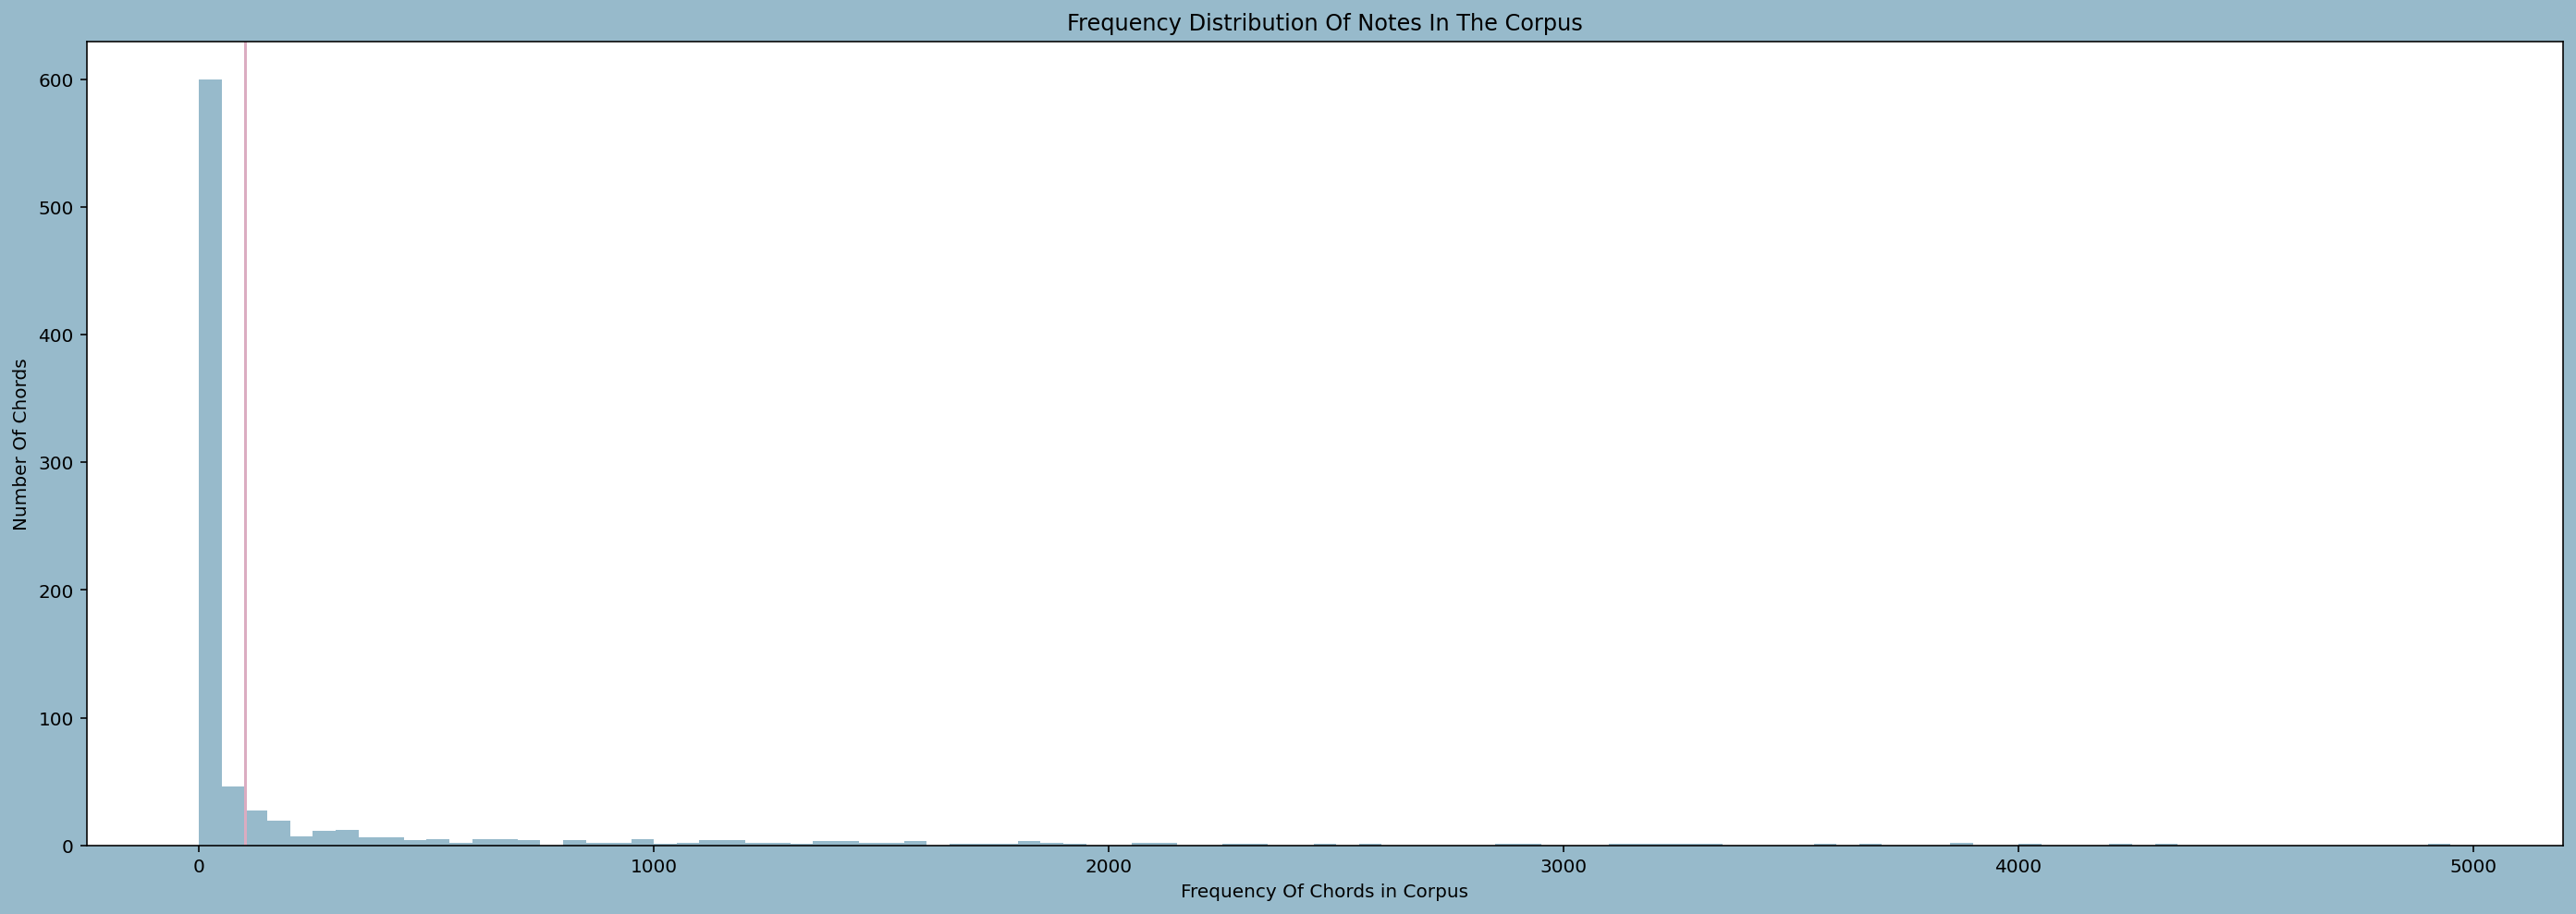

In [9]:
# Plotting the distribution of Notes
plt.figure(figsize=(24,8),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [10]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))


Total number of notes that occur less than 100 times: 646


In [11]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 179636


## Data Preprocessing ##
Notes are basically sound waves. In music, we have certain specific combinations of Frequency and Wavelength standardized as said notes. Our Corpus has the name of that note. As we parsed the data at the time of loading we took the help of the music21 library (by nice people at MIT); The library fetches Frequency, Wavelength, duration etc for the given notes.

**In this section, I will be performing the following:**

**Creating a dictionary:** Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN.

**Encoding and Splitting the corpus.**: Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify.

**Assigning X and y:** The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model.

**Splitting Train and Seed datasets** To create music we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value.

**Creating a list of sorted unique characters**



In [12]:
# Storing all the unique characters present in the corpus to bult a mapping dict. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 179636
Number of unique characters: 555


**Encoding and splitting the Corpus as Labels and Targets**

In [13]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 179596


In [14]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [15]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building ##

We will be using an LSTM Model on this project

For the model building we will need to go through 4 steps
* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the model**

In [16]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 555)               142635    
                                                                 
Total params: 2,048,555
Trainable params: 2,048,555
Non-

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
562/562 [==============================] - 504s 891ms/step - loss: 4.8605
Epoch 2/200
562/562 [==============================] - 545s 969ms/step - loss: 4.8219
Epoch 3/200
562/562 [==============================] - 574s 1s/step - loss: 4.8193
Epoch 4/200
562/562 [==============================] - 509s 906ms/step - loss: 4.8177
Epoch 5/200
562/562 [==============================] - 467s 831ms/step - loss: 4.8166
Epoch 6/200
562/562 [==============================] - 477s 849ms/step - loss: 4.8154
Epoch 7/200
562/562 [==============================] - 473s 842ms/step - loss: 4.8140
Epoch 8/200
562/562 [==============================] - 466s 830ms/step - loss: 4.7899
Epoch 9/200
562/562 [==============================] - 457s 813ms/step - loss: 4.7519
Epoch 10/200
562/562 [==============================] - 460s 818ms/step - loss: 4.7472
Epoch 11/200
562/562 [==============================] - 454s 808ms/step - loss: 4.7445
Epoch 12/200
562/562 [==============================] -